In [226]:
import numpy as np
from scipy.integrate import quad

import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [227]:
S = 100. # initial asset price
K = 100. # strike
v = 0.1 # initial variance
tau = 1. # time to maturity
r = 0.03 # risk free rate

κ = 1.5768 # rate of mean reversion of variance process
theta = 0.0398 # long-term mean variance
lambd = 0 # risk premium of variance
sigma = 0.3 # volatility of volatility
rho = -0.5711 # correlation between variance and stock process

In [228]:
def heston_cf(phi, x, v, tau, r, kappa, theta, lambd, sigma, rho):
    """
    Characteristic function (for P_2)
    """
    a = κ * theta
    b = κ + lambd

    d = np.sqrt((rho*sigma*phi*1j - b)**2 + sigma**2*(phi*1j + phi**2))
    g = (b - rho*sigma*phi*1j + d) / (b - rho*sigma*phi*1j - d)
    
    exp1 = r*phi*1j*tau + a/sigma**2 * ((b-rho*sigma*phi*1j+d)*tau - 2*np.log((1-g*np.exp(d*tau))/(1-g)))
    exp2 = v/sigma**2 * (b-rho*sigma*phi*1j+d) * (1-np.exp(d*tau)) / (1-g*np.exp(d*tau))
    exp3 = 1j*phi*x
    
    return np.exp(exp1 + exp2 + exp3)


def heston_integrand(phi, x, K, v, tau, r, κ, theta, lambd, sigma, rho):
    """
    Integrand of the inverse Fourier transform
    """
    args = (x, v, tau, r, κ, theta, lambd, sigma, rho)
    
    return np.real(
        np.exp(-1j*phi*np.log(K)) * heston_cf(phi-1j, *args) / (1j*phi) - 
        np.exp(-1j*phi*np.log(K)) * heston_cf(phi, *args) / (1j*phi) * K
    )


def heston_price(S, K, v, tau, r, κ, theta, lambd, sigma, rho):
    """
    Calculate the price of an European call option under Heston model
    """
    x = np.log(S)
    args = (x, K, v, tau, r, κ, theta, lambd, sigma, rho)
    
    I = quad(heston_integrand, 0, 100, args=args)
    
    return 1/2 * (S - K * np.exp(-r*tau)) + 1/np.pi * np.exp(-r*tau) * I[0]

In [229]:
def heston_price_mc(S0, K, v0, tau, r, κ, theta, sigma, rho):
    """
    Calcuate the price of an European call option with Euler discretization
    """
    m = 1000
    n = 250
    dt = tau / n
    
    S = np.zeros((n+1, m))
    V = np.zeros((n+1, m))
    S[0] = S0
    V[0] = v0

    for i in range(1, n + 1):
        Z_V = np.random.standard_normal(m)
        Z_S = rho * Z_V + np.sqrt(1 - rho ** 2) * np.random.standard_normal(m)
        V[i] = V[i-1] + \
                κ * (theta - np.maximum(V[i-1], 0)) * dt + \
                sigma * np.sqrt(np.maximum(V[i-1], 0)) * Z_V * np.sqrt(dt)
        S[i] = S[i-1] * \
                np.exp((r - np.maximum(V[i-1], 0) / 2) * dt + \
                       np.sqrt(np.maximum(V[i-1], 0)) * Z_S * np.sqrt(dt))
        
    return np.exp(-r*tau) * np.mean(np.maximum(S[-1, :] - K, 0))

In [230]:
prices_mc = np.zeros(1000)
for i in range(len(prices_mc)):
    prices_mc[i] = heston_price_mc(S, K, v, tau, r, κ, theta, sigma, rho)

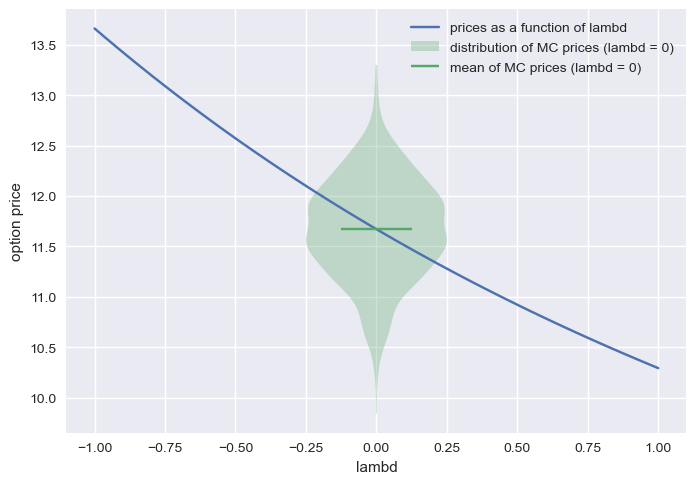

In [231]:
lambd_ = np.linspace(-1, 1)
prices_ = np.zeros(len(lambd_))

for i in range(len(lambd_)):
    prices_[i] = heston_price(S, K, v, tau, r, κ, theta, lambd_[i], sigma, rho)

plt.plot(lambd_, prices_)
plt.violinplot(prices_mc, positions=[0], showmeans=True, showextrema=False)
plt.xlabel('lambd')
plt.ylabel('option price')
plt.legend([
    'prices as a function of lambd', 
    'distribution of MC prices (lambd = 0)', 
    'mean of MC prices (lambd = 0)'])
plt.show()